I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import statistics
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.stats as astats
# CIAO Imports
# import ciao_contrib.runtool
# from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('All', 'Bona'), value='All')

II. Number of Bins

In [3]:
# Set ID
set_id = set_widget.value
# Reduce data for useful input to data representation
# df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
# df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
# df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id,min_counts = 40)
# Load Input
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
# Group Data
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')
# Filter for Minimum 40 events
#df_eventfiles_group = df_eventfiles_group.filter(lambda x: len(x) > 49).groupby('obsreg_id')
#keep_obsreg = list(df_eventfiles_group.groups.keys())
#df_properties_group = df_properties_group.filter(lambda x: x.name in keep_obsreg).groupby('obsreg_id')

# Print info
print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)


Number of Eventfiles:  82283
Number of Property Sets:  82283


Run

In [2]:
nbin_E_list = []
nbin_dt_list = []
nbin_t_list = []
bb_t_list = []

sturges_list = []

scotts_E_list = []
scotts_dt_list = []
scotts_t_list = []

T_list = []
N_list = []

count = 0
fails = 0
count_limit = df_eventfiles_group.ngroups
id_fail = []
id_pass = []

dt_min_list = []
dt_max_list = []

for id_name, df in df_eventfiles_group:
    try:
        # Copy df
        df = df.copy()
        df.sort_values(by='time', inplace = True) 
        df.reset_index(drop=True, inplace = True)
        # Define histogram boundaries
        E_start = np.log10(500)
        E_end = np.log10(7000)
        t_start = 0
        t_end = 1
        dt_start = 0
        dt_end = 1
        # IDs
        obsid = id_name.split("_")[0]
        regid = id_name.split("_")[1]
        # Eventfile length and duration
        N_length = len(df) 
        T_duration = max(df["time"])-min(df["time"])
        # Add E, t, dt columns
        df["E"] = np.log10(df["energy"])
        E_min = min(df["E"])
        E_max = max(df["E"])
        df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
        df["delta_time"] = df['time'].diff().shift(-1)
        df = df[df["delta_time"].notna()]
        df["dt"] = (df['delta_time'] - df['delta_time'].mean()) / df['delta_time'].std() 
        dt_min =  min(df["dt"])
        dt_max =  max(df["dt"])
        df["dt"] = (df["dt"]-min(df["dt"]))/(max(df["dt"])-min(df["dt"]))
  
        # Freedman-Diaconis rule ENERGY
        iqr_E = np.subtract(*np.percentile(df['E'], [75, 25], axis=0)) #IQ range
        binwidth_E = 2 * iqr_E / (len(df['E']) ** (1/3))
        nbins_E = (df['E'].max() - df['E'].min()) / binwidth_E
        nbins_E = int(np.ceil((E_end - E_start) / (E_max - E_min) * nbins_E))
        # Freedman-Diaconis rule DT
        iqr_dt = np.subtract(*np.percentile(df['dt'], [75, 25], axis=0)) #IQ range
        binwidth_dt = 2 * iqr_dt / (len(df['dt']) ** (1/3))
        nbins_dt = int(np.ceil((df['dt'].max() - df['dt'].min()) / binwidth_dt))
        # Freedman-Diaconis rule T
        iqr_t = np.subtract(*np.percentile(df['t'], [75, 25], axis=0)) #IQ range
        binwidth_t = 2 * iqr_t / (len(df['t']) ** (1/3))
        nbins_t = int(np.ceil((df['t'].max() - df['t'].min()) / binwidth_t))
        # Bayesian Blocks Rule 
        bb_bins = astats.bayesian_blocks(df['time'], fitness='events', p0=1)
        bb_nbins = len(bb_bins) - 1

        # Sturges Rule
        k = int(np.ceil(1 + np.log2(N_length)))
        # Scotts Rule
        w_E = 3.5 * np.std(df['E']) / (N_length ** (1/3))
        w_dt = 3.5 * np.std(df['dt']) / (N_length ** (1/3))
        w_t = 3.5 * np.std(df['t']) / (N_length ** (1/3))
        k_E = int(np.ceil((df['E'].max() - df['E'].min()) / w_E))
        k_dt = int(np.ceil((df['dt'].max() - df['dt'].min()) / w_dt))
        k_t = int(np.ceil((df['t'].max() - df['t'].min()) / w_t))

        # Append optimal bins lists
        nbin_E_list.append(nbins_E)
        nbin_dt_list.append(nbins_dt)
        nbin_t_list.append(nbins_t)
        sturges_list.append(k)
        scotts_E_list.append(k_E)
        scotts_dt_list.append(k_dt)
        scotts_t_list.append(k_t)
        T_list.append(T_duration)
        N_list.append(N_length)

        dt_min_list.append(dt_min)
        dt_max_list.append(dt_max)

        bb_t_list.append(bb_nbins)

        count = count + 1
        print(f'Counter: {count} / {count_limit}')
        clear_output(wait=True)
        id_pass.append(id_name)
    except:
        # Fails
        fails = fails + 1
        print(f'Fails: {fails} / {count_limit}')
        clear_output(wait=True)
        id_fail.append(id_fail)


NameError: name 'df_eventfiles_group' is not defined

In [ ]:
Failed

Save

In [8]:
# Set ID
set_id = set_widget.value
# Describe 
describe = 'FINAL'
# Save FD
with open(f'{global_path}/{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_E_list, file)
with open(f'{global_path}/{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_dt_list, file)
with open(f'{global_path}/{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_t_list, file)
# Save Sturges
with open(f'{global_path}/{set_id}/n_sturges-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(sturges_list, file)
# Save Scott
with open(f'{global_path}/{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_E_list, file)
with open(f'{global_path}/{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_dt_list, file)
with open(f'{global_path}/{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_t_list, file)

# Save BB
with open(f'{global_path}/{set_id}/nbin_BB-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(bb_t_list, file)

# Save T
with open(f'{global_path}/{set_id}/Tlist-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(T_list, file)
# Save N
with open(f'{global_path}/{set_id}/Nlist-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(N_list, file)

# Save min scaled delta_time
with open(f'{global_path}/{set_id}/dt_min_list-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(dt_min_list, file)
# Save min delta_time
with open(f'{global_path}/{set_id}/dt_max_list-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(dt_max_list, file)

# Save IDs
with open(f'{global_path}/{set_id}/idpass-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_pass, file)
with open(f'{global_path}/{set_id}/idfail-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_fail, file)

Load

In [4]:
# Set ID
set_id = set_widget.value
# Describe 
describe = 'FINAL'
with open(f'{global_path}/{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_dt_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_t_list = pickle.load(file)
# Open Sturges
with open(f'{global_path}/{set_id}/n_sturges-{set_id}-{describe}.pickle', "rb") as file:
    sturges_list = pickle.load(file)
# Open Scott
with open(f'{global_path}/{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_E_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_dt_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)

# Save BB
with open(f'{global_path}/{set_id}/nbin_BB-{set_id}-{describe}.pickle', "rb") as file:
    bb_t_list = pickle.load(file)

# Open T
with open(f'{global_path}/{set_id}/Tlist-{set_id}-{describe}.pickle', "rb") as file:
    T_list = pickle.load(file)
# Open N
with open(f'{global_path}/{set_id}/Nlist-{set_id}-{describe}.pickle', "rb") as file:
    N_list = pickle.load(file)
# Open dt min max
with open(f'{global_path}/{set_id}/dt_min_list-{set_id}-{describe}.pickle', "rb") as file:
    dt_min_list = pickle.load(file)
with open(f'{global_path}/{set_id}/dt_max_list-{set_id}-{describe}.pickle', "rb") as file:
    dt_max_list = pickle.load(file)

# Open IDs
with open(f'{global_path}/{set_id}/idpass-{set_id}-{describe}.pickle', "rb") as file:
    id_pass = pickle.load(file)
with open(f'{global_path}/{set_id}/idfail-{set_id}-{describe}.pickle', "rb") as file:
    id_fail = pickle.load(file)

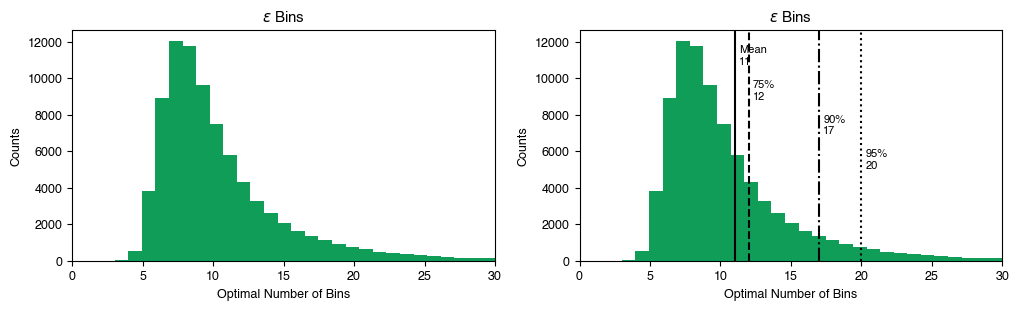

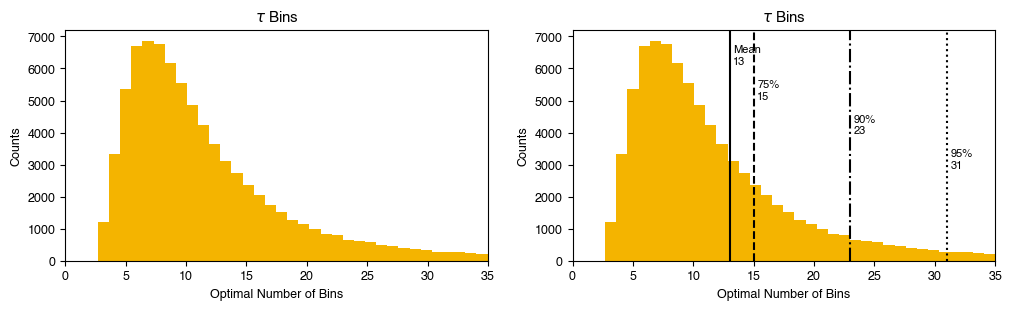

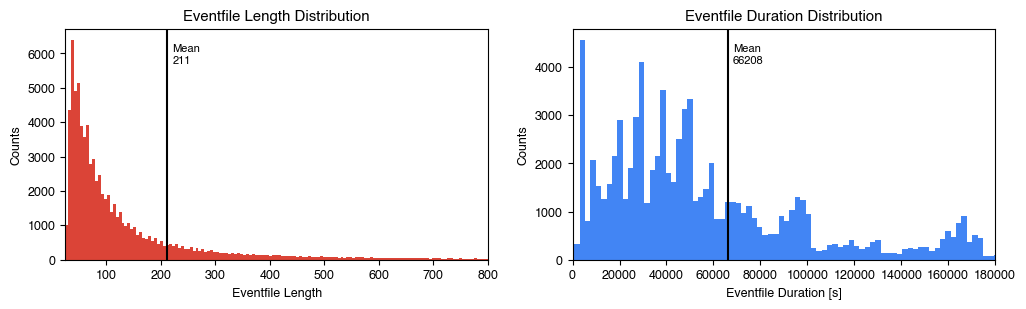

In [5]:
# Edt binning plotter
def binning_plotter(bin_list,show_percentiles = True, xlim =[0,100],nbins = 100, farbe = 'schwarz',title = 'XXX'):
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    google_purple = '#6f2da8'
    if farbe == 'blau':
        colour = google_blue
    elif farbe == 'rot':
        colour = google_red
    elif farbe == 'gelb':
        colour = google_yellow
    elif farbe == 'gruen':
        colour = google_green
    elif farbe == 'lila':
        colour = google_purple
    elif farbe == 'schwarz':
        colour = 'black'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    # Plot Binning without percentiles
    axs[0].hist(bin_list, color = colour,bins=nbins)
    axs[0].set_xlabel('Optimal Number of Bins')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(title)
    axs[0].set_xlim(xlim)
    # Plot delta_time Binning histograms
    axs[1].hist(bin_list, color = colour,bins=nbins)
    axs[1].set_xlabel('Optimal Number of Bins')
    axs[1].set_ylabel('Counts')
    axs[1].set_title(title)
    axs[1].set_xlim(xlim)
    # Plot Percentiles
    if show_percentiles:
        # Energy statistical values
        n_avg = int(np.ceil(sum(bin_list)/len(bin_list)))
        n_99 = int(np.percentile(bin_list, 99))
        n_95 = int(np.percentile(bin_list, 95))
        n_90 = int(np.percentile(bin_list, 90))
        n_75 = int(np.percentile(bin_list, 75))
        n_50 =  int(np.percentile(bin_list, 50))
        # Plot
        textsize = 8
        axs[1].axvline(n_avg,color='black',linestyle='-')
        plt.text(n_avg+0.3, .85, f'Mean\n{n_avg}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)

        # axs[1].axvline(n_99,color='black',linestyle='--')
        # plt.text(n_99+0.3, .4, f'99%\n{n_99}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        axs[1].axvline(n_95,color='black',linestyle=':')
        plt.text(n_95+0.3, .40, f'95%\n{n_95}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        axs[1].axvline(n_90,color='black',linestyle='-.')
        plt.text(n_90+0.3, .55, f'90%\n{n_90}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        axs[1].axvline(n_75,color='black',linestyle='--')
        plt.text(n_75+0.3, .7, f'75%\n{n_75}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        # axs[1].axvline(n_75,color='black',linestyle=':')
        # plt.text(n_75+0.3, .7, f'75%\n{n_75}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
    
    return

def t_binning_plotter(N_list,T_list,show_percentiles = False,xlim_N = [0,800],xlim_T = [0,180000], farbe1 = 'schwarz', farbe2 = 'schwarz'):
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    google_purple = '#6f2da8'
    if farbe1 == 'blau':
        colour1 = google_blue
    elif farbe1 == 'rot':
        colour1 = google_red
    elif farbe1 == 'gelb':
        colour1 = google_yellow
    elif farbe1 == 'gruen':
        colour1 = google_green
    elif farbe1 == 'lila':
        colour1 = google_purple
    elif farbe1 == 'schwarz':
        colour1 = 'black'

    if farbe2 == 'blau':
        colour2 = google_blue
    elif farbe2 == 'rot':
        colour2 = google_red
    elif farbe2 == 'gelb':
        colour2 = google_yellow
    elif farbe2 == 'gruen':
        colour2 = google_green
    elif farbe2 == 'lila':
        colour2 = google_purple
    elif farbe2 == 'schwarz':
        colour2 = 'black'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'

    # Freedman-Diaconis rule N
    iqr_N = np.subtract(*np.percentile(N_list, [75, 25], axis=0)) #IQ range
    binwidth_N = 2 * iqr_N / (len(N_list) ** (1/3))
    nbins_N = int(np.ceil((max(N_list) - min(N_list)) / binwidth_N))
    # Freedman-Diaconis rule T
    iqr_T = np.subtract(*np.percentile(T_list, [75, 25], axis=0)) #IQ range
    binwidth_T = 2 * iqr_T / (len(T_list) ** (1/3))
    nbins_T = int(np.ceil((max(T_list) - min(T_list)) / binwidth_T))
    
    # Create subplots 
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    # Plot Energy Binning histograms
    axs[0].hist(N_list, color = colour1 ,bins = nbins_N)
    axs[0].set_xlabel(r'Eventfile Length')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(r'Eventfile Length Distribution')
    axs[0].set_xlim(xlim_N)
    # Plot delta_time Binning histograms
    axs[1].hist(T_list, color = colour2 ,bins = nbins_T)
    axs[1].set_xlabel(r'Eventfile Duration [s]')
    axs[1].set_ylabel('Counts')
    axs[1].set_title(r'Eventfile Duration Distribution')
    axs[1].set_xlim(xlim_T)
    # Plot Percentiles
    textsize = 8
    N_avg = int(np.ceil(sum(N_list)/len(N_list)))
    T_avg = int(np.ceil(sum(T_list)/len(T_list)))
    axs[0].axvline(N_avg,color='black',linestyle='-')
    plt.text(N_avg+10, .85, f'Mean\n{N_avg}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)
    axs[1].axvline(T_avg,color='black',linestyle='-')
    plt.text(T_avg+2000, .85, f'Mean\n{T_avg}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
    
    if show_percentiles:
        # Energy statistical values
        N_avg = int(np.ceil(sum(N_list)/len(N_list)))
        N_99 = int(np.percentile(N_list, 99))
        N_95 = int(np.percentile(N_list, 95))
        N_90 = int(np.percentile(N_list, 90))
        N_75 = int(np.percentile(N_list, 75))
        N_50 =  int(np.percentile(N_list, 50))
        N_25 =  int(np.percentile(N_list, 25))
        # dt statistical values
        T_avg = int(np.ceil(sum(T_list)/len(T_list)))
        T_99 = int(np.percentile(T_list, 99))
        T_95 = int(np.percentile(T_list, 95))
        T_90 = int(np.percentile(T_list, 90))
        T_75 = int(np.percentile(T_list, 75))
        T_50 = int(np.percentile(T_list, 50))
        T_25 = int(np.percentile(T_list, 25))
        # Plot
        textsize = 8
        #axs[0].axvline(N_99,color='black',linestyle='--')
        #plt.text(N_99+10, .90, f'99%\n{N_99}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)
        axs[0].axvline(N_95,color='black',linestyle=':')
        plt.text(N_95+10, .40, f'95%\n{N_95}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)
        axs[0].axvline(N_90,color='black',linestyle='-.')
        plt.text(N_90+10, .55, f'90%\n{N_90}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)
        axs[0].axvline(N_75,color='black',linestyle='--')
        plt.text(N_75+10, .7, f'75%\n{N_75}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)

        # axs[0].axvline(N_50,color='black',linestyle=':')
        # plt.text(N_50+10, .90, f'50%\n{N_50}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)
        # axs[0].axvline(N_25,color='black',linestyle=':')
        # plt.text(N_25+10, .90, f'25%\n{N_25}', transform=axs[0].get_xaxis_transform(),fontsize=textsize)

        #axs[1].axvline(T_99,color='black',linestyle='--')
        #plt.text(T_99+2000, .90, f'99%\n{T_99}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        axs[1].axvline(T_95,color='black',linestyle=':')
        plt.text(T_95+2000, .40, f'95%\n{T_95}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        axs[1].axvline(T_90,color='black',linestyle='-.')
        plt.text(T_90+2000, .55, f'90%\n{T_90}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        axs[1].axvline(T_75,color='black',linestyle='--')
        plt.text(T_75+2000, .7, f'75%\n{T_75}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)

        # axs[1].axvline(T_50,color='black',linestyle=':')
        # plt.text(T_50+2000, .90, f'50%\n{T_50}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
        # axs[1].axvline(T_25,color='black',linestyle=':')
        # plt.text(T_25+2000, .90, f'25%\n{T_25}', transform=axs[1].get_xaxis_transform(),fontsize=textsize)
    return

# Set ID
set_id = set_widget.value
perc_dt = np.percentile(nbin_dt_list,99)
filt_dt = [x for x in nbin_dt_list if x <= perc_dt]
perc_E = np.percentile(nbin_dt_list,99)
filt_E = [x for x in nbin_E_list if x <= perc_E]

binning_plotter(filt_E,show_percentiles = True, xlim =[0,30],nbins = 85, farbe = 'gruen',title = r'$\epsilon$ Bins')
binning_plotter([x * 0.9 for x in filt_dt],show_percentiles = True, xlim =[0,35],nbins = 83, farbe = 'gelb',title = r'$\tau$ Bins')

t_binning_plotter(N_list, T_list,xlim_N = [25,800],xlim_T = [0,180000], farbe1 = 'rot', farbe2 = 'blau')

Show

Number of Eventfiles:  82282

 Freedman-Diaconis Rule, depends on length of an eventfile and IQR
Min. nE (Freedman-Diaconis): 3
Min. ndt (Freedman-Diaconis):  3
Min. nt (Freedman-Diaconis):  2
Max. nE (Freedman-Diaconis): 169
Max. ndt (Freedman-Diaconis):  2547115
Max. nt (Freedman-Diaconis):  23307
Avg. nE (Freedman-Diaconis): 11
Avg. ndt (Freedman-Diaconis):  110
Avg. nt (Freedman-Diaconis):  7
Med. nE (Freedman-Diaconis): 9.0
Med. ndt (Freedman-Diaconis):  11.0
Med. nt (Freedman-Diaconis):  5.0
Mode nE (Freedman-Diaconis): 7
Mode ndt (Freedman-Diaconis):  8
Mode nt (Freedman-Diaconis):  5
95percentile nE (Freedman-Diaconis):  20.0
95percentile ndt (Freedman-Diaconis):  38.0
95percentile nt (Freedman-Diaconis):  10.0
90percentile nE (Freedman-Diaconis):  17.0
90percentile ndt (Freedman-Diaconis):  27.0
90percentile nt (Freedman-Diaconis):  8.0
80percentile nE (Freedman-Diaconis):  13.0
80percentile ndt (Freedman-Diaconis):  19.0
80percentile nt (Freedman-Diaconis):  7.0
75percentile 

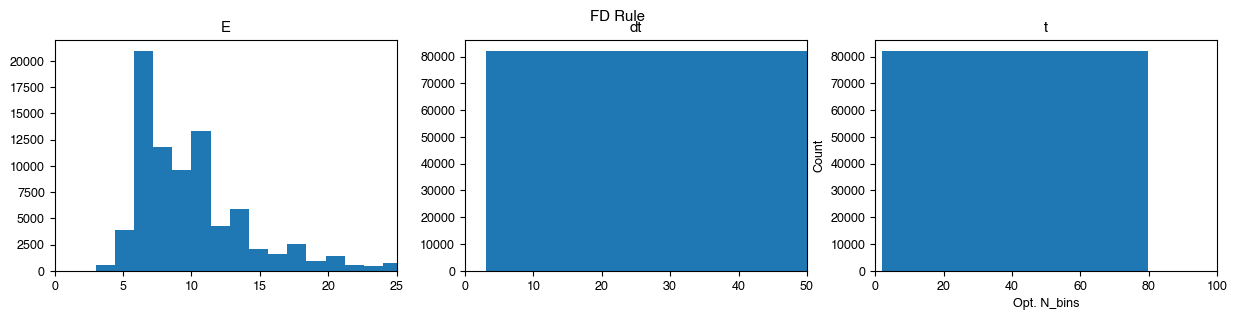

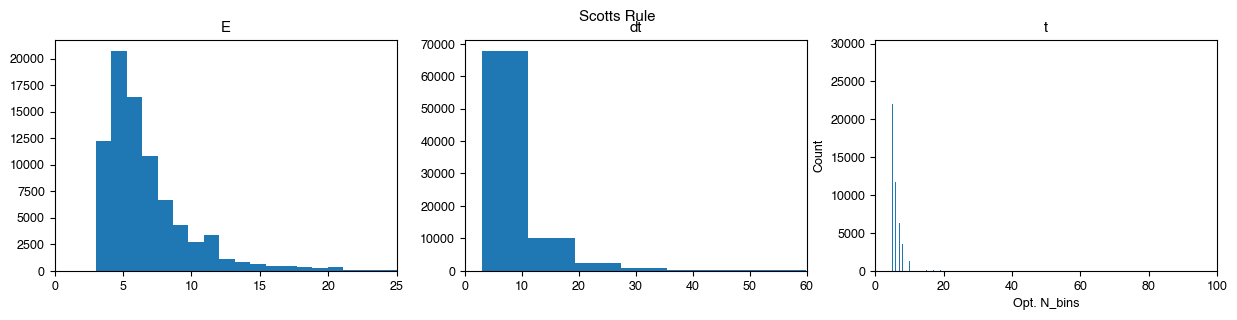

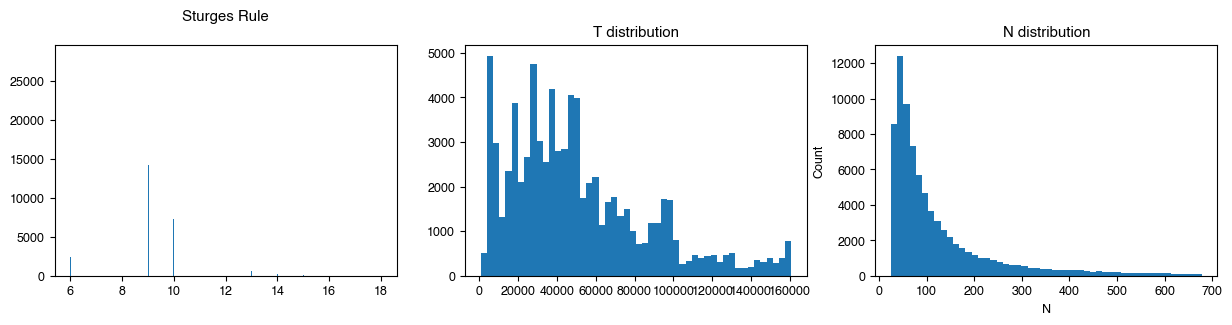

In [11]:
# See Overleaf for advantages and disadvantages etc.
# Thoughts: Best method is the Freedman-Diaconis (FD) rule, but can check bounds of Sturges and Scotts to see if our result with FD falls within that range
# Question is now: Do we use the MAX or AVG for the number of bins (look at distributions!), AVG may not represent the data well in some cases (hides variability), 
# but Max values may be a few single outliers...LOOK AT DISTRIBUTIONS
print("Number of Eventfiles: ", len(sturges_list))

# FD
print('\n Freedman-Diaconis Rule, depends on length of an eventfile and IQR')
print('Min. nE (Freedman-Diaconis):', min(nbin_E_list))
print('Min. ndt (Freedman-Diaconis): ', min(nbin_dt_list))
print('Min. nt (Freedman-Diaconis): ', min(nbin_t_list))
print('Max. nE (Freedman-Diaconis):', max(nbin_E_list))
print('Max. ndt (Freedman-Diaconis): ', max(nbin_dt_list))
print('Max. nt (Freedman-Diaconis): ', max(nbin_t_list))
print('Avg. nE (Freedman-Diaconis):', int(np.ceil(sum(nbin_E_list)/len(nbin_E_list))))
print('Avg. ndt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_dt_list)/len(nbin_dt_list))))
print('Avg. nt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_t_list)/len(nbin_t_list))))
print('Med. nE (Freedman-Diaconis):', statistics.median(nbin_E_list))
print('Med. ndt (Freedman-Diaconis): ', statistics.median(nbin_dt_list))
print('Med. nt (Freedman-Diaconis): ', statistics.median(nbin_t_list))
print('Mode nE (Freedman-Diaconis):', statistics.mode(nbin_E_list))
print('Mode ndt (Freedman-Diaconis): ', statistics.mode(nbin_dt_list))
print('Mode nt (Freedman-Diaconis): ', statistics.mode(nbin_t_list))
print('95percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 95))
print('95percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 95))
print('95percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 95))
print('90percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 90))
print('90percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 90))
print('90percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 90))
print('80percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 80))
print('80percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 80))
print('80percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 80))
print('75percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 75))
print('75percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 75))
print('75percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 75))
print('50percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 50))
print('50percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 50))
print('50percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 50))

#BB
print('Min. t (BB): ', min(bb_t_list))
print('Max. t (BB): ', max(bb_t_list))
print('Avg. t (BB):', np.mean(bb_t_list))
print('Med. t (BB):', statistics.median(bb_t_list))
print('Mode. t (BB):', statistics.mode(bb_t_list))
print('95percentile t (BB): ', np.percentile(bb_t_list, 95))
print('90percentile t (BB): ', np.percentile(bb_t_list, 90))
print('80percentile t (BB): ', np.percentile(bb_t_list, 80))
print('75percentile t (BB): ', np.percentile(bb_t_list, 75))
print('50percentile t (BB): ', np.percentile(bb_t_list, 50))


print('95percentile T: ', np.percentile(T_list, 95))
print('90percentile T: ', np.percentile(T_list, 90))
print('80percentile T: ', np.percentile(T_list, 80))
print('75percentile T: ', np.percentile(T_list, 75))
print('50percentile T: ', np.percentile(T_list, 50))
print('T avg: ', np.mean(T_list))

print('99.9percentile N: ', np.percentile(N_list, 99.9))
print('99percentile N: ', np.percentile(N_list, 99))
print('98percentile N: ', np.percentile(N_list, 98))
print('97percentile N: ', np.percentile(N_list, 97))
print('96percentile N: ', np.percentile(N_list, 96))
print('95percentile N: ', np.percentile(N_list, 95))
print('90percentile N: ', np.percentile(N_list, 90))
print('80percentile N: ', np.percentile(N_list, 80))
print('75percentile N: ', np.percentile(N_list, 75))
print('50percentile N: ', np.percentile(N_list, 50))
print('N avg: ', np.mean(N_list))

print('Min dt: ', min(dt_min_list))
print('Max dt: ', max(dt_max_list))



# Scotts
print('\n Scotts Rule, depends on length of an eventfile and standard deviation')
print('Min. nE (Scotts): ', min(scotts_E_list))
print('Min. ndt (Scotts): ', min(scotts_dt_list))
print('Min. nt (Scotts): ', min(scotts_t_list))
print('Max. nE (Scotts): ', max(scotts_E_list))
print('Max. ndt (Scotts): ', max(scotts_dt_list))
print('Max. nt (Scotts): ', max(scotts_t_list))
print('Avg. nE (Scotts): ', int(np.ceil(sum(scotts_E_list)/len(scotts_E_list))))
print('Avg. ndt (Scotts): ', int(np.ceil(sum(scotts_dt_list)/len(scotts_dt_list))))
print('Avg. nt (Scotts): ', int(np.ceil(sum(scotts_t_list)/len(scotts_t_list))))
print('Med. nE (Scotts): ', statistics.median(scotts_E_list))
print('Med. ndt (Scotts): ', statistics.median(scotts_dt_list))
print('Med. nt (Scotts): ', statistics.median(scotts_t_list))
print('95percentile nE (Scotts): ', np.percentile(scotts_E_list, 95))
print('95percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 95))
print('95percentile nt (Scotts): ', np.percentile(scotts_t_list, 95))
print('90percentile nE (Scotts): ', np.percentile(scotts_E_list, 90))
print('90percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 90))
print('90percentile nt (Scotts): ', np.percentile(scotts_t_list, 90))
print('80percentile nE (Scotts): ', np.percentile(scotts_E_list, 80))
print('80percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 80))
print('80percentile nt (Scotts): ', np.percentile(scotts_t_list, 80))
print('75percentile nE (Scotts): ', np.percentile(scotts_E_list, 75))
print('75percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 75))
print('75percentile nt (Scotts): ', np.percentile(scotts_t_list, 75))

# Sturges
print('\n Sturges Rule, only dependents on length of an eventfile (hence same nbins for E and dt), assumes normal distribution of data')
print('Min. n (Sturges):', min(sturges_list)) # Assumes normal distr tho
print('Max. n (Sturges):', max(sturges_list)) # Assumes normal distr tho
print('Avg. n (Sturges):', int(np.ceil(sum(sturges_list)/len(sturges_list)))) # Assumes normal distr tho
print('Med. n (Sturges):', statistics.median(sturges_list)) # Assumes normal distr tho
print('95percentile n (Sturges): ', np.percentile(sturges_list, 95))
print('90percentile n (Sturges): ', np.percentile(sturges_list, 90))
print('75percentile n (Sturges): ', np.percentile(sturges_list, 75))

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Can also plot them on top of each other for comparison!!!

# IDEA: get only 2-3std away from mean and plot distributions again

# FD Rule
percentile_99 = np.percentile(nbin_E_list, 99)

filtered_list = [x for x in nbin_E_list if x <= percentile_99]


fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15, 3))
fig.suptitle('FD Rule\n')
#ax1.hist(nbin_E_list,bins=100)
ax1.hist(filtered_list,bins=20)
ax1.set_title('E')
ax1.set_xlim([0,25])
#ax1.set_xlim([np.percentile(nbin_E_list,0), np.percentile(nbin_E_list,99)])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(nbin_dt_list,bins=100)
ax2.set_title('dt')
ax2.set_xlim([0,50])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax3.hist(nbin_t_list,bins=300)
ax3.set_title('t')
ax3.set_xlim([0,100])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

# Scotts Rule
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15, 3))
fig.suptitle('Scotts Rule')
ax1.hist(scotts_E_list,bins=100)
ax1.set_title("E")
ax1.set_xlim([0,25])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(scotts_dt_list,bins=100)
ax2.set_title("dt")
ax2.set_xlim([0,60])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax3.hist(scotts_t_list,bins=300)
ax3.set_title("t")
ax3.set_xlim([0,100])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

percentile_95_T = np.percentile(T_list, 95)
percentile_95_N = np.percentile(N_list, 95)

filtered_list_T = [x for x in T_list if x <= percentile_95_T]
filtered_list_N = [x for x in N_list if x <= percentile_95_N]

# Sturges
fig2, (ax1, ax2,ax3)  = plt.subplots(1, 3,figsize=(15, 3))
ax1.hist(sturges_list,bins=500)
ax1.set_title('Sturges Rule\n')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(filtered_list_T,bins=50)
ax2.set_title('T distribution')
plt.xlabel('T')
plt.ylabel('Count')
ax3.hist(filtered_list_N,bins=50)
ax3.set_title('N distribution')
plt.xlabel('N')
plt.ylabel('Count')



plt.show()

#Fails 
#print("Fails: ", id_fail)

In [6]:
bb_t_list = []
count = 0
fails = 0
count_limit = df_eventfiles_group.ngroups
id_fail = []
id_pass = []

for id_name, df in df_eventfiles_group:
    try:
        # Copy df
        df = df.copy()
        df.sort_values(by='time', inplace = True) 
        df.reset_index(drop=True, inplace = True)
 
        # Bayesian Blocks Rule 
        bb_bins = astats.bayesian_blocks(df['time'].tolist(), fitness='events',p0 = 1) # p0 = 0.01 or so
        bb_nbins = len(bb_bins) - 1
        bb_t_list.append(bb_nbins)
        count = count + 1
        print(f'Counter: {count} / {count_limit}')
        print(bb_nbins)
        clear_output(wait=True)
        id_pass.append(id_name)
    except:
        # Fails
        fails = fails + 1
        print(f'Fails: {fails} / {count_limit}')
        clear_output(wait=True)
        id_fail.append(id_fail)


Counter: 18715 / 82283
1


: 

In [3]:
def babe(t):
    """Bayesian Blocks Implementation

    By Jake Vanderplas.  License: BSD
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = len(t)

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1],
                            0.5 * (t[1:] + t[:-1]),
                            t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        fit_vec[1:] += best[:K]
    # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points], len(edges[change_points])


In [4]:
bb_t_list = []
count = 0
fails = 0
count_limit = df_eventfiles_group.ngroups
id_fail = []
id_pass = []

for id_name, df in df_eventfiles_group:
    try:
        # Copy df
        df = df.copy()
        df.sort_values(by='time', inplace = True) 
        df.reset_index(drop=True, inplace = True)
 
        # Bayesian Blocks Rule 
        bb_bins, bb_nbins = babe(df['time'].tolist()) # p0 = 0.01 or so
        bb_t_list.append(bb_nbins)
        count = count + 1
        print(f'Counter: {count} / {count_limit}')
        print(bb_nbins)
        clear_output(wait=True)
        id_pass.append(id_name)
    except:
        # Fails
        fails = fails + 1
        print(f'Fails: {fails} / {count_limit}')
        clear_output(wait=True)
        id_fail.append(id_fail)

Counter: 32197 / 82283
2


In [ ]:
#BB

print('Min. t (BB): ', min(bb_t_list))
print('Max. t (BB): ', max(bb_t_list))
print('Avg. t (BB):', np.mean(bb_t_list))
print('Med. t (BB):', statistics.median(bb_t_list))
print('Mode. t (BB):', statistics.mode(bb_t_list))
print('99.9percentile t (BB): ', np.percentile(bb_t_list, 99.9))
print('99percentile t (BB): ', np.percentile(bb_t_list, 99))
print('95percentile t (BB): ', np.percentile(bb_t_list, 95))
print('90percentile t (BB): ', np.percentile(bb_t_list, 90))
print('80percentile t (BB): ', np.percentile(bb_t_list, 80))
print('75percentile t (BB): ', np.percentile(bb_t_list, 75))
print('50percentile t (BB): ', np.percentile(bb_t_list, 50))

Min. t (BB):  1
Max. t (BB):  412
Avg. t (BB): 3.920688356039522
Med. t (BB): 3
Mode. t (BB): 3
99percentile t (BB):  45.0
95percentile t (BB):  8.0
90percentile t (BB):  7.0
80percentile t (BB):  5.0
75percentile t (BB):  5.0
50percentile t (BB):  3.0
